In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import numpy as np
import xarray as xr
from exults.tensorial import Long
import json
import pandas as pd
from transformers import AutoTokenizer
import extractive_structures.gradients as pg
from extractive_structures import ROOT

In [46]:
sns.set_theme()
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_style("ticks")

## Training ranks

In [54]:
with open(ROOT/'results/first_hop_train.json') as f:
    first_hop = json.load(f)
with open(ROOT/'results/second_hop_train.json') as f:
    second_hop = json.load(f)

In [55]:
def viz_traj(ax, data, train_name, test_name, title):
    df = pd.DataFrame(data).rename(columns={train_name: 'Fact Rank', test_name: 'Implications Rank'})
    sns.lineplot(df, x='Fact Rank', y='Implications Rank', ax=ax, estimator=None, sort=False)
    ax.set_xlim([-0.5, 10.5])
    ax.set_ylim([-0.5, 10.5])
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])
    ax.set_title(title)
    # ax.xaxis.set_label_coords(0.5, -0.10)

In [56]:
def viz_traj(ax, data, train_name, test_name, title, legend):
    df = pd.DataFrame(Long(data).factorize([train_name, test_name], 'metric', 'rank').data)
    df = df.assign(metric=df.metric.map(lambda x: {
        train_name: 'Train (facts)',
        test_name: 'Test (impl.)',
    }[x]))
    df = df.rename(columns={'rank': 'Rank', 'epoch': 'Epoch'})
    sns.lineplot(df, x='Epoch', y='Rank', style='metric', ax=ax, estimator=None, legend=legend)
    # ax.set_xlim([-0.5, 11])
    ax.set_ylim([-0.5, 11])
    ax.set_xticks([0, 8])
    ax.set_yticks([0, 10])
    ax.set_title(title)
    ax.xaxis.set_label_coords(0.5, -0.15)

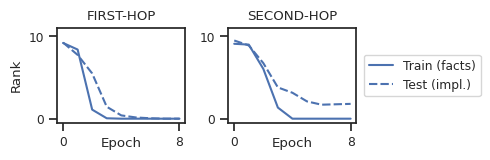

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(5, 1.75))
viz_traj(axs[0], first_hop, 'train', 'test', 'FIRST-HOP', False)
viz_traj(axs[1], second_hop, 'train', 'test', 'SECOND-HOP', True)
axs[1].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.5)
axs[1].set_ylabel('')
fig.tight_layout()
plt.savefig(ROOT / 'figures/twohop_train.pdf', bbox_inches="tight")

## Extractive scores

In [58]:
left_es = torch.load(ROOT/'results/left_extractive_scores.pt')
right_es = torch.load(ROOT/'results/right_extractive_scores.pt')


names = ['Upstream', 'Downstream', 'Informative']

order = [1, 2, 0]

def reorder(order, arr):
    return [arr[idx] for idx in order]

names = reorder(order, names)
left_es = reorder(order, left_es)
right_es = reorder(order, right_es)
def flatten_mlp(mask):
    return mask.mlps.cpu().numpy()[0, :, :] # seq, layer
def flatten_att(mask):
    return mask.attn.cpu().numpy()[0, :, :, :].sum(axis=-1) # seq, layer
left_seq = ('The people in the city John Doe is from speak', 'Japanese')
right_seq = ('The mayor of the city that contains Tower Bridge is', 'Grace Miller')
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-1.7-7B-hf")
def get_toks(test_pt, in_only=False):
    if in_only:
        inputs = pg.tokenize_and_mask_batch([test_pt], tokenizer)
        toks = inputs['input_ids'][0, inputs['labels'][0] == -100]
        return [
            tokenizer.decode(tok) 
            for tok in toks
        ]
    return [tokenizer.decode(tok) for tok in pg.tokenize_and_mask_batch([test_pt], tokenizer)['input_ids'][0]]
left_toks = get_toks(left_seq, True)
right_toks = get_toks(right_seq, True)
def plot_score(ax, seq, score, x_ticks, y_ticks, vmin, vmax, freeze_zero):
    if freeze_zero is not None:
        min_constraint = min(0, score.min())
        max_constraint = max(0, score.max()) * freeze_zero / (1 - freeze_zero)
        abs_constraint = max(min_constraint, max_constraint)
        vmin = -abs_constraint
        vmax = abs_constraint * (1 - freeze_zero) / freeze_zero
    score = score[:len(seq), :]
    sns.heatmap(score.T, ax=ax, xticklabels=seq if x_ticks else False, cbar=True, yticklabels=y_ticks, vmin=vmin, vmax=vmax)
    if y_ticks:
        ax.set_yticks([0.5, 31.5])
    ax.invert_yaxis()

ModuleNotFoundError: No module named 'pretune'

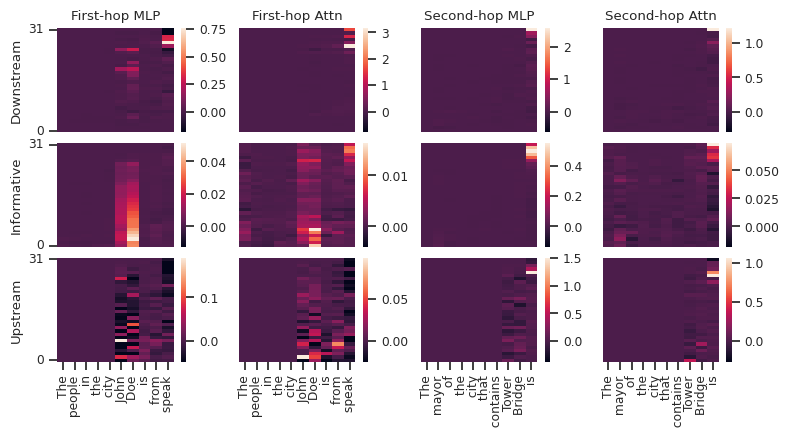

In [59]:
vmin, vmax = None, None
freeze_zero = 0.2
fig, axs = plt.subplots(3, 4, figsize=(8, 4.5))

for i in range(3):
    plot_score(axs[i, 0], left_toks, flatten_mlp(left_es[i]), i==2, True, vmin, vmax, freeze_zero)
    plot_score(axs[i, 1], left_toks, flatten_att(left_es[i]), i==2, False, vmin, vmax, freeze_zero)
    
    plot_score(axs[i, 2], right_toks, flatten_mlp(right_es[i]), i==2, False, vmin, vmax, freeze_zero)
    plot_score(axs[i, 3], right_toks, flatten_att(right_es[i]), i==2, False, vmin, vmax, freeze_zero)
    
    axs[i, 0].set_ylabel(names[i])
for i, name in enumerate(['First-hop MLP', 'First-hop Attn', 'Second-hop MLP', 'Second-hop Attn']):
    axs[0, i].set_title(name)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25, hspace=0.1)
plt.savefig(ROOT / 'figures/twohop_extractive_scores.pdf', bbox_inches="tight")

## Layer freezing

In [15]:
with open(ROOT / 'results/layer_freezing.json', 'r') as fp:
    freeze_results = json.load(fp)

In [16]:
df = pd.DataFrame(freeze_results).pivot(index='freeze', columns='dataset', values=['train', 'test'])
df

train        test      
dataset    left right  left right
freeze                           
all        9.70  8.75  9.40  8.55
early      6.05  0.40  9.10  1.50
early_pre  0.00  0.00  7.35  0.60
late       0.00  0.10  0.45  7.25
late_pre   0.00  0.00  0.25  7.60
none       0.00  0.00  0.45  1.50

In [153]:
from jinja2 import Template

In [174]:
def get_row(freeze_name):
    keys = [
        ('train', 'left'),
        ('test', 'left'),
        ('train', 'right'),
        ('test', 'right')
    ]
    return ' & '.join([
        f'{df.loc[freeze_name, k]:.2f}'
        if df.loc[freeze_name, k] < 2. 
        else f'\\textcolor{{red}}{{{df.loc[freeze_name, k]:.2f}}}'
    for k in keys
    ])

In [175]:
get_row('all')

'\\textcolor{red}{9.20} & \\textcolor{red}{9.25} & \\textcolor{red}{9.10} & \\textcolor{red}{9.50}'

In [176]:
latex = r"""
    \begin{tabular}{c c c c c}
    \toprule 
     & \multicolumn{2}{c}{\textbf{First-hop}} & \multicolumn{2}{c}{\textbf{Second-hop}} \\
    \cmidrule(lr){2-3} \cmidrule(lr){4-5}
    \textbf{Frozen Layers} & Fact & Impl. & Fact & Impl. \\
    \midrule 
    None & {{ get_row('none') }}\\
    Early & {{ get_row('early') }}\\
    Late  & {{ get_row('late') }}\\
    All  & {{ get_row('all') }}\\
    Early (pre)  & {{ get_row('early_pre') }}\\
    Late (pre)  & {{ get_row('late_pre') }}\\
    \bottomrule
    \end{tabular}
"""

In [177]:
print(Template(latex).render(get_row=get_row))


    \begin{tabular}{c c c c c}
    \toprule 
     & \multicolumn{2}{c}{\textbf{First-hop}} & \multicolumn{2}{c}{\textbf{Second-hop}} \\
    \cmidrule(lr){2-3} \cmidrule(lr){4-5}
    \textbf{Frozen Layers} & Fact & Impl. & Fact & Impl. \\
    \midrule 
    None & 0.00 & 0.00 & 0.00 & 1.80\\
    Early & \textcolor{red}{5.10} & \textcolor{red}{8.40} & 0.95 & 1.85\\
    Late  & 0.00 & 0.00 & 0.10 & \textcolor{red}{6.30}\\
    All  & \textcolor{red}{9.20} & \textcolor{red}{9.25} & \textcolor{red}{9.10} & \textcolor{red}{9.50}\\
    Early (pre)  & 0.00 & \textcolor{red}{6.50} & 0.00 & 0.50\\
    Late (pre)  & 0.00 & 0.10 & 0.00 & \textcolor{red}{6.60}\\
    \bottomrule
    \end{tabular}


## Data ordering

In [17]:
with open(ROOT /'results/data_ordering_logs.json', 'r') as fp:
    all_logs = json.load(fp)

In [18]:
long_logs = Long(sum([
    (
        Long(d['train']).attach(order=d['order'], time='train').data +
        Long(d['test']).attach(order=d['order'], time='test').data
    )
    for d in all_logs
], []))

In [19]:
train_df = long_logs.get_all(time='train')
test_df = long_logs.get_all(time='test')

In [20]:
def viz_traj(ax, data, train_name, test_name, title, legend):
    df = pd.DataFrame(data).rename(columns={train_name: 'Fact Rank', test_name: 'Implications Rank'})
    df['order'] = df['order'].replace(['joint', 'left_first', 'both_first'], ['Joint', 'Facts first', 'Impl. first'])
    sns.lineplot(df, x='Fact Rank', y='Implications Rank', hue='order', ax=ax, sort=False, estimator=None, legend=legend)
    ax.set_xlim([-0.5, 11])
    ax.set_ylim([-0.5, 11])
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])
    ax.set_title(title)

In [21]:
def viz_traj(ax, data, train_name, test_name, title, legend):
    df = pd.DataFrame(Long(data).factorize(['left', 'both'], 'metric', 'rank').data)
    df['order'] = df['order'].replace(['joint', 'left_first', 'both_first'], ['Joint', 'Facts first', 'Impl. first'])
    df['metric'] = df['metric'].replace(['left', 'both'], ['Facts', 'Impl.'])
    df = df.rename(columns={'order': 'Order', 'metric': 'Metric', 'epoch': 'Epoch', 'rank': 'Rank'})
    sns.lineplot(df, x='Epoch', y='Rank', style='Metric', hue='Order', ax=ax, estimator=None, legend=legend)
    ax.set_ylim([-0.5, 11])
    ax.set_xticks([0, 8])
    ax.set_yticks([0, 10])
    ax.set_title(title)
    ax.xaxis.set_label_coords(0.5, -0.15)

In [22]:
epochs = len(train_df.get_all(order='joint')) - 1

In [23]:
squashed_epochs = np.linspace(0, epochs/2, epochs+1).tolist() + np.linspace(epochs/2, epochs, epochs+1).tolist()
train_df = Long(
    train_df.get_all(order='joint').data +
    train_df.get_all(order='left_first').insert_col('epoch', squashed_epochs).data + 
    train_df.get_all(order='both_first').insert_col('epoch', squashed_epochs).data
)

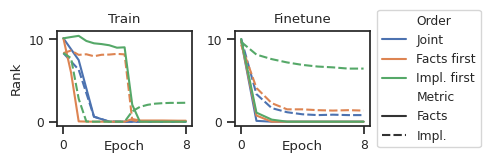

In [24]:


fig, axs = plt.subplots(1, 2, figsize=(5, 1.75))
viz_traj(axs[0], train_df.data, 'left', 'both', 'Train', False)
viz_traj(axs[1], test_df.data, 'left', 'both', 'Finetune', True)
axs[1].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.5)
axs[1].set_ylabel('')
fig.tight_layout()
plt.savefig(ROOT / 'figures/data_ordering.pdf', bbox_inches="tight")

## Grafting

In [25]:
with open(ROOT / 'results/grafting.json', 'r') as fp:
    results = json.load(fp)

In [26]:
arr = Long(results).to_data_array(['name', 'metric'], 'value')
arr

<xarray.DataArray 'value' (name: 3, metric: 4)> Size: 96B
array([[8.54761905, 9.11904762, 8.91666667, 0.        ],
       [3.30952381, 1.13095238, 8.4047619 , 0.08333333],
       [0.42857143, 8.41666667, 9.19047619, 0.32142857]])
Coordinates:
  * name     (name) <U16 192B 'left_2' 'left_2_graft' 'left_2_graft_bad'
  * metric   (metric) <U6 96B 'both_1' 'both_2' 'left_1' 'left_2'

In [245]:
def get_row(name):
    return ' & '.join([
        f'{arr.sel(name=name, metric=metric):.2f}'
        for metric in ['both_2', 'both_1', 'left_2']
    ])

In [27]:
template = r"""

    \begin{tabular}{c c c c}
    \toprule 
    \textbf{Weights} & $\impl \facts F'$ & $\impl \facts F$ & $\facts F'$ \\
    \midrule
     $\weights_{\facts F'}$ & {{ get_row('left_2') }}\\
    $\weights_{\facts F'} + \weights_{\facts F,\impl \facts F} - \weights_{\facts F}$ & {{ get_row('left_2_graft') }}\\
    $\weights_{\facts F'} + \weights_{\impl \facts F} - \weights$& {{ get_row('left_2_graft_bad') }} \\
    
    \midrule
    \bottomrule
    \end{tabular}
"""

In [28]:
print(Template(template).render(get_row=get_row))

NameError: name 'Template' is not defined

## Grafting localization

In [39]:
both_informative, test_downstream = torch.load(ROOT / 'results/grafting_correlations.pt')

In [40]:
def flatten_data(x, y):
    data_list = [
        [
            {
                'x': a.item(),
                'y': b.item()
            }
            for a, b in zip(x.mlps.flatten(), y.mlps.flatten())
        ],
        [
            {
                'x': a.item(),
                'y': b.item()
            }
            for a, b in zip(x.attn.flatten(), y.attn.flatten())
        ]
    ]
    return data_list

In [41]:
inf_down = flatten_data(both_informative, test_downstream)

In [42]:
import scipy.stats

In [43]:
def viz_corr(ax, data, title):
    df = pd.DataFrame(data).rename(columns={'x': 'Informative', 'y': 'Downstream'})
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df['Informative'], df['Downstream'])
    sns.regplot(df, x='Informative', y='Downstream', ci=None, ax=ax, marker='.', scatter_kws=dict(s=4.), line_kws=dict(lw=1.5))
    ax.set_title(title)
    # print(p_value)
    ax.text(0.95, 0.95, f'$r^2={r_value**2 : .2f}$', transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='right',
        fontsize=10
    )

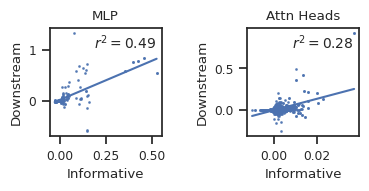

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
viz_corr(axs[0], inf_down[0], 'MLP')
viz_corr(axs[1], inf_down[1], 'Attn Heads')
fig.tight_layout()
plt.savefig(ROOT / 'figures/grafting_localization.pdf', bbox_inches="tight")